In [1]:
import pandas as pd
import numpy as np
from google_patent_scraper import scraper_class
import json
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('inventors_filtered_by_cn_kr.csv')
# replace 'na' gender with unknown
df = df.replace(np.nan, 'unknown', regex=True)
df

,application_number,filing_date,inventor_name_first,inventor_name_middle,inventor_name_last,gender,inventor_rank,inventor_country_code,pat_no,claim_no
0,9331991,2000-01-03,SEO,YOUNG,JEONG,andy,1.0,KR,6451348,unknown
1,9331991,2000-01-03,KUIWON,unknown,CHOI,unknown,2.0,KR,6451348,unknown
2,9331991,2000-01-03,ICK-CHAN,unknown,KWON,unknown,3.0,KR,6451348,unknown
3,9331991,2000-01-03,YONG-HEE,unknown,KIM,female,4.0,KR,6451348,unknown
4,9331991,2000-01-03,JAE,BONG,CHOI,andy,5.0,KR,6451348,unknown
...,...,...,...,...,...,...,...,...,...,...
1265321,17135301,2020-12-28,Sung An,unknown,GWEON,unknown,1.0,KR,10970633,unknown
1265322,17135301,2020-12-28,Yongjoong,unknown,KIM,unknown,2.0,KR,10970633,unknown
1265323,17135301,2020-12-28,Bongnam,unknown,KANG,unknown,3.0,KR,10970633,unknown
1265324,17135033,2020-12-28,Kye-Hyeon,unknown,KIM,unknown,1.0,KR,10970645,unknown


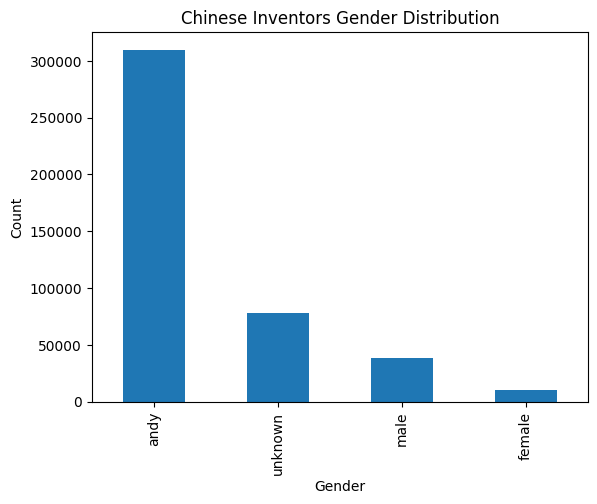

In [3]:
chinese_inventors = df[df['inventor_country_code'] == 'CN']
korean_inventors = df[df['inventor_country_code'] == 'KR']

chinese_gender_distribution = chinese_inventors['gender'].value_counts().drop('na')
# barplot it
chinese_gender_distribution.plot.bar()
plt.title('Chinese Inventors Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Count')

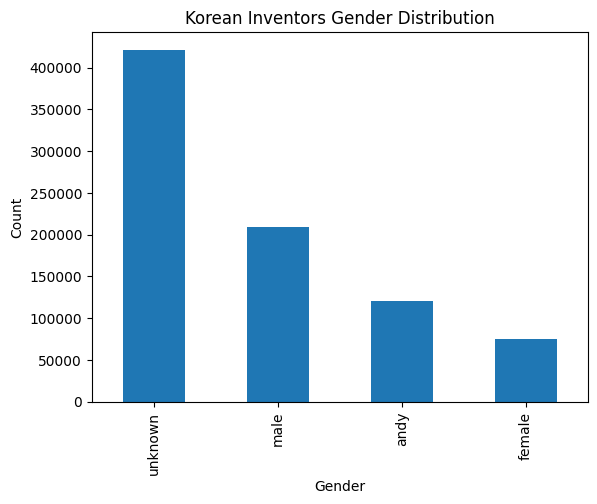

In [4]:
korean_gender_distribution = korean_inventors['gender'].value_counts().drop('na')
# barplot it
korean_gender_distribution.plot.bar()
plt.title('Korean Inventors Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

In [8]:
# first get the patent page
def get_patent_page(patno, countryCode):
    # check if patno starts with an alphabet
    if not patno[0].isalpha():
        patno = 'US' + patno
    url = 'https://patents.google.com/patent/' + patno
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    return (soup, countryCode)

# second find the corresponding patent number in the inventors' native country code (CN or KR)
def get_patent_native(result):
    soup = result[0]
    countryCode = result[1]

    patents_translated = soup.find_all('li', {'itemprop': 'applicationsByYear'})
    patent_in_native = []
    for i in patents_translated:
        for a in i.find_all('a'):
            patentNum = a['href'].split('/')[2]
            if countryCode in patentNum:
                patent_in_native.append(patentNum)
    if patent_in_native:
        return patent_in_native[0]
    else:
        return None

# third get the inventors' names in the native language
def get_patent_inventors(patent_native):
    if patent_native:
        soup = get_patent_page(patent_native, 'xx')[0]
        return list(map(lambda x: x['content'], soup.find_all('meta', {'name': 'DC.contributor', 'scheme': 'inventor'})))
    else:
        return None

get_patent_inventors('KR0181252B1')

['정서영', '최귀원', '권익찬', '김용희', '최재봉', '이규백']

In [5]:
def get_patent(patno, countryCode):
    # first get the patent page
    if not patno[0].isalpha():
        patno = 'US' + patno
    url = 'https://patents.google.com/patent/' + patno
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')

    # second find the corresponding patent number in the inventors' native country code (CN or KR)
    patents_translated = soup.find_all('li', {'itemprop': 'applicationsByYear'})
    patent_in_native = []
    for i in patents_translated:
        for a in i.find_all('a'):
            patentNum = a['href'].split('/')[2]
            if countryCode in patentNum:
                patent_in_native.append(patentNum)
    if not patent_in_native:
        return None
    else:
        # third get the inventors' names in the native language
        soup = get_patent_page(patent_in_native[0], 'xx')[0]
        inventors =  list(map(lambda x: x['content'], soup.find_all('meta', {'name': 'DC.contributor', 'scheme': 'inventor'})))
        # append writers to a file with patno
        with open('inventors_' + countryCode + '.txt', 'a') as f:
            f.write(patno + ':' + ','.join(inventors) + '\n')
        return inventors

In [6]:
# get all unique pat_no in df and put them in a dataframe (using the first value to get the country code)
unsorted = df.groupby('pat_no').first()[['inventor_country_code']].reset_index()
all_patents = pd.DataFrame(df['pat_no'].unique(), columns=['pat_no'])
all_patents = all_patents.merge(unsorted, on='pat_no', how='left')
all_patents

,pat_no,inventor_country_code
0,6451348,KR
1,7197313,KR
2,6239641,KR
3,6396787,KR
4,6170758,KR
...,...,...
439949,D915475,CN
439950,D911457,CN
439951,D911456,CN
439952,10970633,KR


In [10]:
# this works with the first 20.. but there's no way we're gonna handle this with the rest lmao (some pat_no are downright weird)
temp = all_patents.head(20).apply(lambda x: get_patent(x.pat_no, x.inventor_country_code), axis=1)
temp

0          [정서영, 최귀원, 권익찬, 김용희, 최재봉, 이규백]
1                                   [손병철]
2                                   [이중호]
3                              [이석정, 이수웅]
4                                   [이황우]
5                         [어윤필, 강경호, 염정덕]
6                                   [송기환]
7                              [이준기, 하웅기]
8           [이진서, 윤효중, 최강, 신재호, 남학현, 차근식]
9                                    None
10                                   None
11                   [김병진, 서강수, 유제용, 강기원]
12                                   None
13                                   None
14                             [김현이, 고영학]
15                                   None
16                                  [김점재]
17                                  [정동진]
18    [홍청일, 김정우, 이상준, 안순길, 최남송, 김계광, 정병선]
19              [김훈식, 김재준, 이상득, 박건유, 김홍곤]
dtype: object

In [11]:
temp2 = all_patents.apply(lambda x: get_patent(x.pat_no, x.inventor_country_code), axis=1)
temp2

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [23]:
scraper = scraper_class()
patent_1 = 'US6451348B1'

err_1, soup_1, url_1 = scraper.request_single_patent(patent_1)
patent_1_parsed = scraper.get_scraped_data(soup_1,patent_1,url_1)
patent_1_parsed['inventor_name']

https://patents.google.com/patent/US6451348B1


'[{"inventor_name": "Seo Young Jeong"}, {"inventor_name": "Kuiwon Choi"}, {"inventor_name": "Ick-Chan Kwon"}, {"inventor_name": "Yong-Hee Kim"}, {"inventor_name": "Jae Bong Choi"}, {"inventor_name": "Kyu Back Lee"}]'

In [17]:
print(json.dumps(patent_1_parsed['forward_cite_no_family'], indent=4))

"[{\"patent_number\": \"WO2004028589A2\", \"priority_date\": \"2002-09-26\", \"pub_date\": \"2004-04-08\"}, {\"patent_number\": \"US20050077221A1\", \"priority_date\": \"2002-01-02\", \"pub_date\": \"2005-04-14\"}, {\"patent_number\": \"WO2006014138A1\", \"priority_date\": \"2004-08-03\", \"pub_date\": \"2006-02-09\"}, {\"patent_number\": \"US20060088567A1\", \"priority_date\": \"2004-10-27\", \"pub_date\": \"2006-04-27\"}, {\"patent_number\": \"US20070104656A1\", \"priority_date\": \"1998-04-30\", \"pub_date\": \"2007-05-10\"}, {\"patent_number\": \"US20070172509A1\", \"priority_date\": \"2006-01-24\", \"pub_date\": \"2007-07-26\"}, {\"patent_number\": \"US20070225388A1\", \"priority_date\": \"2004-01-28\", \"pub_date\": \"2007-09-27\"}, {\"patent_number\": \"US20080194709A1\", \"priority_date\": \"2004-11-22\", \"pub_date\": \"2008-08-14\"}, {\"patent_number\": \"US20100048755A1\", \"priority_date\": \"2006-11-17\", \"pub_date\": \"2010-02-25\"}, {\"patent_number\": \"US20120225100A1

In [36]:
for key, value in patent_1_parsed.items():
    if 'cite' in key:
        for x in value[1:-1].split():
            if "KR" in x:
                print(x.replace('"', '').replace(',', ''))

KR100381382B1
KR100376083B1
KR100429000B1


In [39]:
patent_2 = 'KR100429000B1'

err_2, soup_2, url_2 = scraper.request_single_patent(patent_2)
patent_2_parsed = scraper.get_scraped_data(soup_2,patent_2,url_2)
patent_2_parsed

https://patents.google.com/patent/KR100429000B1


{'inventor_name': '[{"inventor_name": "\\ubc15\\ud0dc\\uad00"}, {"inventor_name": "\\uc724\\uc900\\uc9c4"}]',
 'assignee_name_orig': '[{"assignee_name": "\\ud55c\\uad6d\\uacfc\\ud559\\uae30\\uc220\\uc6d0"}]',
 'assignee_name_current': '[]',
 'pub_date': '2003-02-20',
 'priority_date': '2001-08-14',
 'grant_date': '2004-04-28',
 'filing_date': '',
 'forward_cite_no_family': '[{"patent_number": "KR100977094B1", "priority_date": "2009-07-13", "pub_date": "2010-08-19"}]',
 'forward_cite_yes_family': '[{"patent_number": "EP1553129B2", "priority_date": "2004-01-08", "pub_date": "2014-07-23"}, {"patent_number": "KR100840394B1", "priority_date": "2007-02-12", "pub_date": "2008-06-23"}, {"patent_number": "KR101265783B1", "priority_date": "2011-09-28", "pub_date": "2013-05-20"}, {"patent_number": "KR101725279B1", "priority_date": "2015-10-27", "pub_date": "2017-04-10"}]',
 'backward_cite_no_family': '[{"patent_number": "JPS61249920A", "priority_date": "1985-04-27", "pub_date": "1986-11-07"}, {"p

In [40]:
patent_2_parsed['inventor_name']

'[{"inventor_name": "\\ubc15\\ud0dc\\uad00"}, {"inventor_name": "\\uc724\\uc900\\uc9c4"}]'

In [59]:
x = b"\\ubc15\\ud0dc\\uad00"
print(x.decode("unicode_escape"))

박태관


In [52]:
print('ㅎㅇ')

ㅎㅇ
